In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import re

from pytorch_lightning import LightningModule, Trainer
import torchvision.models as models
#from pl_bolts.callbacks import ORTCallback
import torchmetrics

# MY local imports
from src.data_stuff import dataset_tools
from src.callback_stuff import LogConfusionMatrix, PatientLevelValidation

from tqdm.notebook import tqdm


print('CUDA available:', torch.cuda.is_available())

CUDA available: True


# ⬇️ Data

In [2]:
ROOT_DIR = '/home/shatz/Documents/tcga_data/data/'
TRAIN_DIR = ROOT_DIR + 'train'
TEST_DIR = ROOT_DIR + 'test'

class params:
    num_workers = 6
    bs = 128

### Transforms
rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)
train_tfms = torchvision.transforms.Compose([
    # torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(rgb_mean, rgb_std),
])
test_tfms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(rgb_mean, rgb_std),
])

### Datasets
train_ds = dataset_tools.ImageFolderWithPaths(TRAIN_DIR, train_tfms)
test_ds = dataset_tools.ImageFolderWithPaths(TEST_DIR, test_tfms)

class_to_idx = train_ds.class_to_idx

# SUBSET FOR TESTING PURPOSES. DELETE LATER #
train_ds = torch.utils.data.Subset(train_ds, np.random.randint(low=0, high=len(train_ds), size=int(len(train_ds)/8)))
test_ds = torch.utils.data.Subset(test_ds, np.random.randint(low=0, high=len(test_ds), size=int(len(test_ds)/8)))

### Dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=params.bs, num_workers=params.num_workers, shuffle=False)



In [3]:
len(train_dl)

92

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


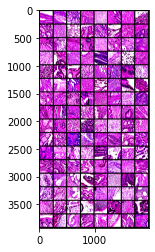

In [4]:
images = next(iter(train_dl))[1]
plt.imshow(torchvision.utils.make_grid(images, padding=20).permute(1, 2, 0))

In [5]:
len(train_ds)

11676

# Model

In [6]:
from src.model_stuff import MyResNet

In [7]:
model = MyResNet.MyResNet()
trainer = Trainer(gpus=1, max_epochs=45, callbacks=[
    LogConfusionMatrix.LogConfusionMatrix(class_to_idx),
    PatientLevelValidation.PatientLevelValidation()])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Logging Confusion Mat initialized
Patient Level Eval initialized


In [8]:
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=test_dl)

/home/shatz/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:531: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type    | Params
-------------------------------------
0 | model    | ResNet  | 11.2 M
1 | criteria | BCELoss | 0     
-------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/shatz/Documents/tcga_data/colorectal_cancer_ai/src/callback_stuff/PatientLevelValidation.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_patient_score = torch.tensor(val_patient_score)
/home/shatz/Documents/tcga_data/colorectal_cancer_ai/src/callback_stuff/PatientLevelValidation.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_patient_target = torch.tensor(self.all_patient_targets[patient])


Training: -1it [00:00, ?it/s]

/home/shatz/miniconda3/envs/moti/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:397: LightningDeprecationWarning: One of the returned values {'batch_outputs', 'acc'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  warning_cache.deprecation(


Validating: 0it [00:00, ?it/s]

/home/shatz/Documents/tcga_data/colorectal_cancer_ai/src/callback_stuff/PatientLevelValidation.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_patient_score = torch.tensor(train_patient_score)
/home/shatz/Documents/tcga_data/colorectal_cancer_ai/src/callback_stuff/PatientLevelValidation.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_patient_target = torch.tensor(self.all_patient_targets[patient])


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [9]:
# !jupyter notebook stop 8888